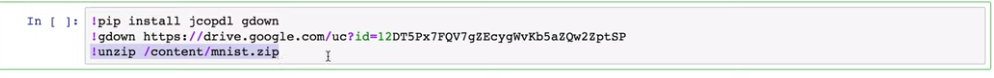

In [ ]:
# !pip install jcopdl gdown
# !gdown https://drive.google.com/uc?id=12DT5Px7gZEcygWvKb5aZQw2zptSP
# !unzip /content/mnist.zip

In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

# Dataset & DataLoader (Hanya Train Set)

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

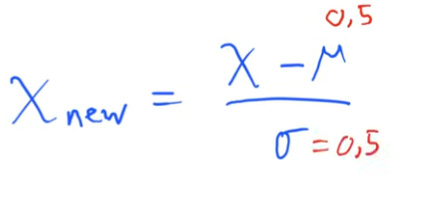

In [5]:
bs = 64


train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # agar menjadi -1 sampai 1 agar menjadi lebih stabil
])

train_set = datasets.ImageFolder("data/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/train'

# Arsitektur & Config 

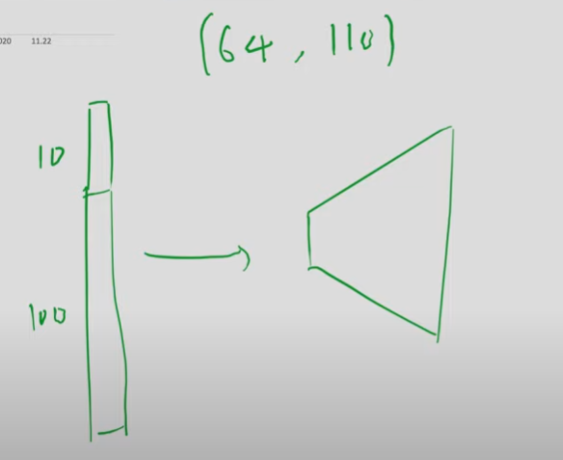

In [5]:
a = torch.rand(64, 100) # bs = 64, z_dim/latent space = 100
b = torch.rand(64, 10) # mempelajari semantic /pakai embedding 10 - label
# concatenite

In [6]:
torch.cat([a, b], dim=1).shape

torch.Size([64, 110])

In [3]:
%%writefile model_cgan.py
import torch
from torch import nn, optim
from jcopdl.layers import linear_block


class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.embed_label = nn.Embedding(n_classes, n_classes)
        self.fc = nn.Sequential(
            linear_block(784 + n_classes, 512, activation='lrelu'),
            linear_block(512, 256, activation='lrelu'),
            linear_block(256, 128, activation='lrelu'),
            linear_block(128, 1, activation='sigmoid')
        )

    def forward(self, x, y):
        x = self.flatten(x)
        y = self.embed_label(y)
        x = torch.cat([x, y], dim=1)
        return self.fc(x)

class Generator(nn.Module):
    def __init__(self, z_dim, n_classes): #z_dim = lattent space
        super().__init__()
        self.z_dim = z_dim
        self.embed_label = nn.Embedding(n_classes, n_classes)
        self.fc = nn.Sequential(
            linear_block(z_dim + n_classes, 128, activation='lrelu'),
            linear_block(128, 256, activation='lrelu', batch_norm=True),
            linear_block(256, 512, activation='lrelu', batch_norm=True),
            linear_block(512, 1024, activation='lrelu', batch_norm=True),
            linear_block(1024, 784, activation='tanh')
        )

    def forward(self, x, y):
        y = self.embed_label(y)
        x = torch.cat([x, y], dim=1)
        return self.fc(x)

    # agar bisa generate gambar palsu
    def generate(self, labels, device): # n -> n fake image
        z = torch.randn((len(labels), self.z_dim), device=device)
        return self.forward(z, labels)


Writing model_gan.py


In [6]:
config = set_config({
    "z_dim" : 100,
    "n_classes": len(train_set.classes),
    "batch_size": bs
})

# Training Preparation -> MCO

In [7]:
from model_cgan import Discriminator, Generator

GAN BENTUKNYA kompetisi, sehingga lossnya naik turun jadi tidak perlu callback early stopping

In [ ]:
D = Discriminator(config.n_classes).to(device)
G = Generator(config.z_dim, config.n_classes).to_device

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002) # jika pakai AdamW bisa terjadi mode collapse maka pakai Adam saja
g_optimizer = optim.Adam(G.parameters(), lr=0.0002) # pakailah lr yang kecil. biasanya dipaper pakai angka 0.0002

Mode Collapse

# Training

In [17]:
import os
from torchvision.utils import save_image

os.makedirs("output/CGAN/", exist_ok=True)
os.makedirs("model/CGAN/", exist_ok=True)

In [ ]:
max_epoch = 300
fix_labels = torch.randint(10, (64, ), device=device)
for epoch in range(max_epochs):
    D.train()
    G.train()
    for real_img, labels in trainloader:
        n_data = real_img.shape[0]
        
        ## Real and Fake Images
        real_img, labels = real_img.to(device), labels.to(device) # real_img ditarik dari data loader yang dipindahkan ke device
        fake_img = G.generator(labels, device) # G.generate kalau bisa sama banyaknya dengan real image agar fair
        
        ## Real and Fake Labels, generate label karena tidak pakai label aslinya sintetik
        # real = 1, fake = 0
        real = torch.ones((n_data, 1), device=device)
        fake = torch.zeros((n_data, 1), device=device)
        
        ## Training Discriminator
        d_optimizer.zero_grad() # reset dulu diawal
        # Real Image -> Discriminator -> real label
        output = D(real_img, labels) # feed forward
        d_real_loss = criterion(output, real) # hitung loss
        
        # Fake image -> Discriminator -> label fake
        output = D(fake_img.detach(), labels) # feed forward, jangan lupa pakai detach karena ini feed forward dari generator sebelumnya
        d_fake_loss = criterion(output, fake) # hitung loss
        
        # backpropagation
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step() # update weight
        
        
        ## Training Generator
        g_optimizer.zero_grad()
        # Fake image -> Discriminator -> tapi label Real
        output = D(fake_img, labels)
        g_loss = criterion(output, real)
        g_loss.backward()
        g_optimizer.step()
    
    # reporting
    if epoch % 5 == 0:
        print(f"Epoch: {epoch:5} | D_loss: {d_loss/2:.5f} | G_loss: {g_loss: .5f}")
    
    
    if epoch % 15 == 0:
        G.eval() # evaluation mode supaya batch norm dimatikan dll.
        epoch = str(epoch).zfill(4)
        fake_img = G.generate(fix_labels, device)
        save_image(fake_img.view(-1, 1, 28, 28), f"output/CGAN/{epoch}.jpg", nrows=8, normalize=True) #NCHW -1 Maksudnya biar pytorch yang menentukan pasti 64
        #fake_img = tensor , normilze = 0-1
        
        torch.save(D, "model/CGAN/discriminator.pth") # kita bisa langsung save modelnya bukan weightnya karena harus ada catatan rekapan yang jelas arsitekturnya harus dalam bentuk file yang sudah dibuat sebelumnya yaitu model_gan.py
        torch.save(G, "model/CGAN/generator.pth")